In [1]:
import os.path as osp
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

import fish_models

In [2]:
import robofish.io

# Data

In [121]:
raycast = fish_models.Raycast(
            n_fish_bins=150,
            n_wall_raycasts=150,
            fov_angle_fish_bins=2*np.pi,
            fov_angle_wall_raycasts=2*np.pi,
            world_bounds=([-50, -50], [50, 50]),
            view_of = ["fish", "fish_oris", "walls"]
        )

In [122]:
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\train"

dset = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\test"

dset_test = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)
data_folder = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\validation"

dset_val = fish_models.IoDataset(
    data_folder,
    raycast,
    output_strings=["poses", "actions", "views"],
    #reduce_dim=1,
    #max_files=10,
)

Loading data from 197 files.


100%|████████████████████████████████████████| 197/197 [00:06<00:00, 28.97it/s]


None
Calculating views from 197 files.


 30%|████████████▍                            | 60/197 [00:17<00:40,  3.34it/s]


KeyboardInterrupt: 

In [5]:
more_than_2_mask = (~np.isnan(dset["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) == 2
more_than_2_mask_test = (~np.isnan(dset_test["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) == 2
more_than_2_mask_val = (~np.isnan(dset_val["poses"]).any(axis=-1).any(axis=-1)).sum(axis=-1) == 2
more_than_2_mask.shape, more_than_2_mask.sum(), more_than_2_mask_test.shape, more_than_2_mask_test.sum(), more_than_2_mask_val.shape, more_than_2_mask_val.sum()

c:\users\olaf\onedrive\öffentlich\master\researchinternship\fish_models\src\fish_models\datasets\io_dataset.py:523: UserWarning: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
  warn(


((197,), 49, (24,), 7, (24,), 4)

In [6]:
swarm_poses = dset["poses"][more_than_2_mask]
swarm_actions = dset["actions"][more_than_2_mask]
swarm_views = dset["views"][more_than_2_mask]
swarm_poses.shape, swarm_actions.shape, swarm_views.shape

((49, 8, 749, 3), (49, 8, 749, 2), (49, 8, 749, 450))

In [7]:
del dset

## Single Track Dataset

In [90]:
small_poses = swarm_poses[:1]
small_actions = swarm_actions[:1]
small_views = swarm_views[:1]
small_poses.shape, small_actions.shape, small_views.shape

((1, 8, 749, 3), (1, 8, 749, 2), (1, 8, 749, 450))

In [91]:
data_list = []
for graph_pose, graph_action, graph_view in zip(small_poses, small_actions, small_views):
    
    graph_pose_nonna = graph_pose[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    graph_view_nonna = graph_view[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    
    graph_pose_nonna = np.swapaxes(graph_pose_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    graph_view_nonna = np.swapaxes(graph_view_nonna,0,1)
    
    num_nodes = graph_pose_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    
    for pose, label, view in zip(graph_pose_nonna, graph_action_nonna, graph_view_nonna):
        x1 = torch.tensor(pose, dtype=torch.float)
        x2 = torch.tensor(np.stack((view[:,:150],
                          view[:,150:300],
                          view[:,300:450]), axis=1), dtype=torch.float)
        y = torch.tensor(label[:,1], dtype=torch.float)
        data = Data(pose=x1, view=x2 , edge_index=edge_index, y=y)
        data_list.append(data)

train_dataset = data_list
train_small_loader = DataLoader(train_dataset, batch_size=128)

## Action Prediction Dataset

In [92]:
arrrr = np.round(swarm_actions[:,:,:,0].flatten()[~np.isnan(swarm_actions[:,:,:,0].flatten())])
arrrr.min(), arrrr.mean(), arrrr.max()

(8.0, 8.0, 8.0)

In [93]:
data_list = []
for graph_pose, graph_action, graph_view in zip(swarm_poses, swarm_actions, swarm_views):
    
    graph_pose_nonna = graph_pose[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    graph_view_nonna = graph_view[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    
    graph_pose_nonna = np.swapaxes(graph_pose_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    graph_view_nonna = np.swapaxes(graph_view_nonna,0,1)
    
    num_nodes = graph_pose_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    
    for pose, label, view in zip(graph_pose_nonna, graph_action_nonna, graph_view_nonna):
        x1 = torch.tensor(pose, dtype=torch.float)
        x2 = torch.tensor(np.stack((view[:,:150],
                          view[:,150:300],
                          view[:,300:450]), axis=1), dtype=torch.float)
        y = torch.tensor(label[:,1], dtype=torch.float)
        data = Data(pose=x1, view=x2 , edge_index=edge_index, y=y)
        data_list.append(data)

train2_loader = DataLoader(data_list, batch_size=256)

In [83]:
swarm_poses_test = dset_test["poses"][more_than_2_mask_test]
swarm_actions_test = dset_test["actions"][more_than_2_mask_test]
swarm_views_test = dset_test["views"][more_than_2_mask_test]
swarm_poses_test.shape, swarm_actions_test.shape, swarm_views_test.shape

c:\users\olaf\onedrive\öffentlich\master\researchinternship\fish_models\src\fish_models\datasets\io_dataset.py:523: UserWarning: There will exist NaNs in the output of this dataset. You might want to use the reduce_dim parameter to get rid of them
  warn(


((7, 8, 749, 3), (7, 8, 749, 2), (7, 8, 749, 450))

In [84]:
del dset_test

In [94]:
data_list = []
for graph_pose, graph_action, graph_view in zip(swarm_poses_test, swarm_actions_test, swarm_views_test):
    
    graph_pose_nonna = graph_pose[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    graph_view_nonna = graph_view[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    
    graph_pose_nonna = np.swapaxes(graph_pose_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    graph_view_nonna = np.swapaxes(graph_view_nonna,0,1)
    
    num_nodes = graph_pose_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    
    for pose, label, view in zip(graph_pose_nonna, graph_action_nonna, graph_view_nonna):
        x1 = torch.tensor(pose, dtype=torch.float)
        x2 = torch.tensor(np.stack((view[:,:150],
                          view[:,150:300],
                          view[:,300:450]), axis=1), dtype=torch.float)
        y = torch.tensor(label[:,1], dtype=torch.float)
        data = Data(pose=x1, view=x2 , edge_index=edge_index, y=y)
        data_list.append(data)

test2_loader = DataLoader(data_list, batch_size=256)

In [86]:
swarm_poses_val = dset_val["poses"][more_than_2_mask_val]
swarm_actions_val = dset_val["actions"][more_than_2_mask_val]
swarm_views_val = dset_val["views"][more_than_2_mask_val]
swarm_poses_val.shape, swarm_actions_val.shape, swarm_views_val.shape

((4, 8, 749, 3), (4, 8, 749, 2), (4, 8, 749, 450))

In [87]:
del dset_val

In [95]:
data_list = []
for graph_pose, graph_action, graph_view in zip(swarm_poses_val, swarm_actions_val, swarm_views_val):
    
    graph_pose_nonna = graph_pose[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    graph_action_nonna = graph_action[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    graph_view_nonna = graph_view[(~np.isnan(graph_pose)).any(axis=-1).any(axis=-1)]
    
    graph_pose_nonna = np.swapaxes(graph_pose_nonna,0,1)
    graph_action_nonna = np.swapaxes(graph_action_nonna,0,1)
    graph_view_nonna = np.swapaxes(graph_view_nonna,0,1)
    
    num_nodes = graph_pose_nonna.shape[1]
    list2 = []
    list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
    for i in range(num_nodes):
        list2.append(np.concatenate((np.arange(num_nodes)[:i], np.arange(num_nodes)[i+1:])))
    list2 = np.concatenate(list2)
    edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
    
    for pose, label, view in zip(graph_pose_nonna, graph_action_nonna, graph_view_nonna):
        x1 = torch.tensor(pose, dtype=torch.float)
        x2 = torch.tensor(np.stack((view[:,:150],
                          view[:,150:300],
                          view[:,300:450]), axis=1), dtype=torch.float)
        y = torch.tensor(label[:,1], dtype=torch.float)
        data = Data(pose=x1, view=x2 , edge_index=edge_index, y=y)
        data_list.append(data)

val2_loader = DataLoader(data_list, batch_size=256)

# Model

In [15]:
from torch_geometric.nn import GraphConv
# from torch_geometric.nn import GATConv
# from torch_geometric.nn import GCNConv

In [27]:
class Pose_plus_Ray_SwarmNet(nn.Module):
    def __init__(self, pos_channels, hidden_channels, out_channels, conv_channels, conv_width):
        super().__init__()
        torch.manual_seed(42)
        self.encoder1 = nn.Conv1d(conv_channels, conv_channels**2, kernel_size=3, stride=2)
        w1 = round((conv_width-3)/2+1)
        self.encoder2 = nn.Conv1d(conv_channels**2, 1, kernel_size=3, stride=2)
        w2 = round((w1-3)/2+1)
        self.gconv1 = GraphConv(pos_channels + w2, hidden_channels)
        self.linear1 = nn.Linear(hidden_channels, hidden_channels)
        self.linear2 = nn.Linear(hidden_channels, hidden_channels)
        self.linear3 = nn.Linear(hidden_channels, hidden_channels)
        self.predictor = nn.Linear(hidden_channels, out_channels)
        self.lrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, pose, views, edge_index):
        views = self.lrelu(self.encoder1(views))
        views = self.lrelu(self.encoder2(views))
        x = self.lrelu(self.gconv1(torch.cat((pose, views.squeeze(1)), dim=1), edge_index))
        x = self.dropout(self.lrelu(self.linear1(x)))
        x = self.dropout(self.lrelu(self.linear2(x)))
        x = self.dropout(self.lrelu(self.linear3(x)))
        x = self.predictor(x)
        return x

# Overfit to one batch

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Pose_plus_Ray_SwarmNet(pos_channels=3, hidden_channels=64, out_channels=1, 
                               conv_channels=3, conv_width=150).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [56]:
data = next(iter(train_small_loader))
data = data.to(device)
true_lbl = data.y.reshape((-1,1))
losses = []
for i in range(2000):
    optimizer.zero_grad()
    pred_lbl = model(data.pose, data.view, data.edge_index)
    loss = criterion(pred_lbl, true_lbl)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f'Epoch: {i:03d}, Train: {loss.item():.4f}', end="\r") 

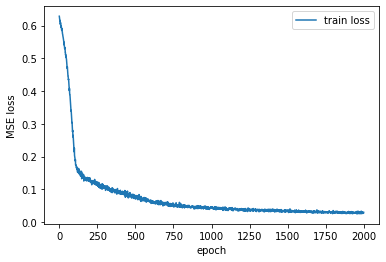

In [57]:
plt.plot(losses, label="train loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

In [58]:
true_lbl[:5], pred_lbl[:5]

(tensor([[ 0.7854],
         [-0.7854],
         [ 0.7854],
         [-0.7854],
         [ 0.7854]], device='cuda:0'),
 tensor([[ 0.7808],
         [-0.7914],
         [ 0.8035],
         [-0.8385],
         [ 0.7641]], device='cuda:0', grad_fn=<SliceBackward0>))

In [59]:
class CouzinModel(fish_models.AbstractModel):
    def __init__(self, regressor, raycast, view_width):
        self.raycast = raycast
        self.regressor = regressor
        self.view_width = view_width

    def choose_action(self, poses_3d, self_id):
        speed = 8
        
        num_nodes = poses_3d.shape[0]
        list2 = []
        list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
        for k in range(num_nodes):
            list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
        list2 = np.concatenate(list2)
        edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
        x_pose = torch.tensor(poses_3d, dtype=torch.float)
        new_view = np.array([self.raycast.cast(poses_3d, new_id) for new_id in range(poses_3d.shape[0])])
        x_view = torch.tensor(np.stack((new_view.reshape(-1, new_view.shape[-1])[:,:self.view_width],
                              new_view.reshape(-1, new_view.shape[-1])[:,self.view_width:self.view_width*2],
                              new_view.reshape(-1, new_view.shape[-1])[:,self.view_width*2:self.view_width*3]), axis=1), 
                              dtype=torch.float)
        
        turn = self.regressor(x_pose, x_view, edge_index).detach().numpy()[self_id].item()
        return speed, turn

100%|███████████████████████████████████████| 128/128 [00:00<00:00, 237.57it/s]


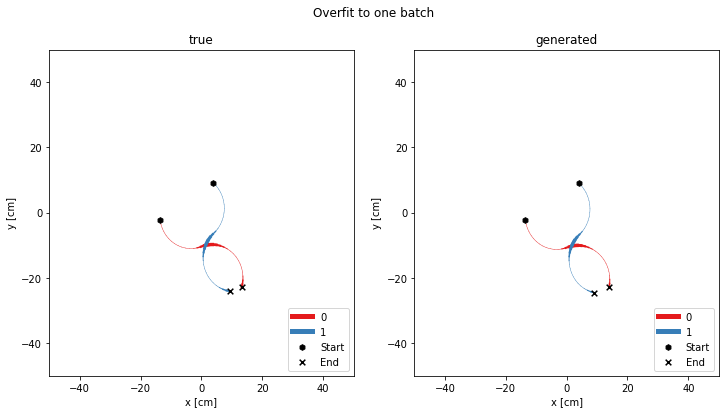

In [60]:
model.eval()
model.to("cpu")
data = data.to("cpu")
raymodel = CouzinModel(regressor=model, raycast=raycast, view_width=150)
generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=25)
n=2
fig, axs = plt.subplots(1,2, figsize=(12,6))
f = generator.as_io_file(np.swapaxes(data.pose.reshape((data.pose.shape[0]//2,2,3)).numpy(),0,1))
f.plot(lw_distances=True, ax=axs[0])
axs[0].set_title("true")
track = generator.create_track(n_guppies=2, trackset_len=data.pose.shape[0]//2,
                               initial_poses=data.pose.reshape((data.pose.shape[0]//2,2,3))[0])
f = generator.as_io_file(track)
f.plot(lw_distances=True, ax=axs[1])
axs[1].set_title("generated")
plt.suptitle("Overfit to one batch")
plt.show()

# Overfit to one track

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Pose_plus_Ray_SwarmNet(pos_channels=3, hidden_channels=64, out_channels=1, 
                               conv_channels=3, conv_width=150).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [67]:
losses = []
for i in range(5000):
    running_loss = 0
    for data in train_small_loader:
        data = data.to(device)
        true_lbl = data.y.reshape((-1,1))
        optimizer.zero_grad()
        pred_lbl = model(data.pose, data.view, data.edge_index)
        loss = criterion(pred_lbl, true_lbl)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss / len(train_small_loader))
    if i % 5 == 0:
        print(f'Epoch: {i:03d}, Train: {losses[-1]:.6f}    ', end="\r")

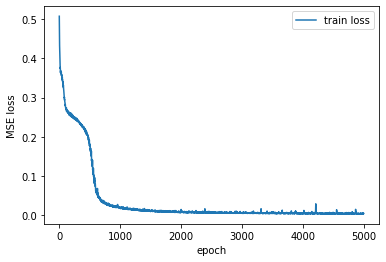

In [68]:
plt.plot(losses, label="train loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

In [69]:
true_lbl[:5], pred_lbl[:5]

(tensor([[0.],
         [0.],
         [0.],
         [0.],
         [0.]], device='cuda:0'),
 tensor([[ 0.0061],
         [-0.0318],
         [-0.0061],
         [-0.0243],
         [-0.0004]], device='cuda:0', grad_fn=<SliceBackward0>))

In [75]:
class CouzinModel(fish_models.AbstractModel):
    def __init__(self, regressor, raycast, view_width):
        self.raycast = raycast
        self.regressor = regressor
        self.view_width = view_width
        self.chosen_actions = [[], []]

    def choose_action(self, poses_3d, self_id):
        speed = 8
        
        num_nodes = poses_3d.shape[0]
        list2 = []
        list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
        for k in range(num_nodes):
            list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
        list2 = np.concatenate(list2)
        edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
        x_pose = torch.tensor(poses_3d, dtype=torch.float)
        new_view = np.array([self.raycast.cast(poses_3d, new_id) for new_id in range(poses_3d.shape[0])])
        x_view = torch.tensor(np.stack((new_view.reshape(-1, new_view.shape[-1])[:,:self.view_width],
                              new_view.reshape(-1, new_view.shape[-1])[:,self.view_width:self.view_width*2],
                              new_view.reshape(-1, new_view.shape[-1])[:,self.view_width*2:self.view_width*3]), axis=1), 
                              dtype=torch.float)
        
        turn = self.regressor(x_pose, x_view, edge_index).detach().numpy()[self_id].item()
        self.chosen_actions[self_id].append(turn)
        return speed, turn

D:\Anaconda3\envs\torch_fish_env\lib\site-packages\torch_geometric\data\storage.py:259: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index', 'view', 'pose', 'y'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(
100%|███████████████████████████████████████| 749/749 [00:03<00:00, 221.04it/s]


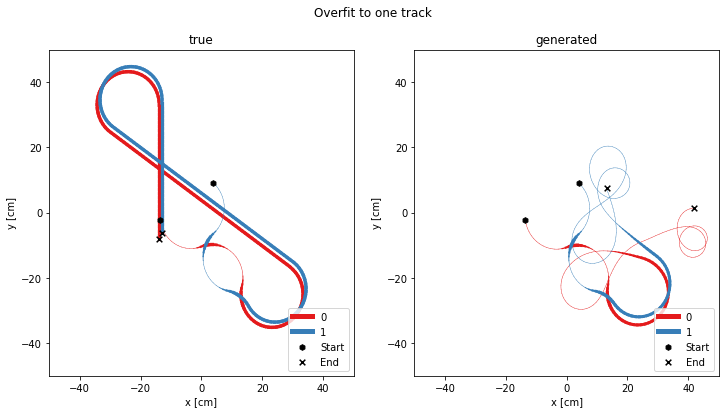

In [76]:
model.eval()
model.to("cpu")
data = data.to("cpu")
raymodel = CouzinModel(regressor=model, raycast=raycast, view_width=150)
generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=25)
n=2
fig, axs = plt.subplots(1,2, figsize=(12,6))
dat = np.concatenate([data.pose.reshape((data.pose.shape[0]//2,2,3)).numpy() for data in train_small_loader])
f = generator.as_io_file(np.swapaxes(dat,0,1))
f.plot(lw_distances=True, ax=axs[0])
axs[0].set_title("true")
track = generator.create_track(n_guppies=2, trackset_len=dat.shape[0],
                               initial_poses=dat[0])
f = generator.as_io_file(track)
f.plot(lw_distances=True, ax=axs[1])
axs[1].set_title("generated")
plt.suptitle("Overfit to one track")
plt.show()

In [77]:
swarm_actions[0,:2,:,1]

array([[ 0.7854,  0.7854,  0.7854, ...,  0.    ,  0.    ,  0.    ],
       [-0.7854, -0.7854, -0.7854, ...,  0.    ,  0.    ,  0.    ]])

In [78]:
np.array(raymodel.chosen_actions)

array([[ 0.75543,  0.75692,  0.76197, ..., -1.73933, -1.72981, -1.8938 ],
       [-0.78604, -0.77935, -0.77683, ..., -0.08502, -0.10028, -0.34385]])

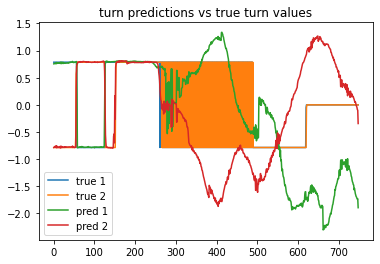

In [79]:
plt.plot(swarm_actions[0,0,:,1], label="true 1")
plt.plot(swarm_actions[0,1,:,1], label="true 2")
plt.plot(np.array(raymodel.chosen_actions)[0], label="pred 1")
plt.plot(np.array(raymodel.chosen_actions)[1], label="pred 2")
plt.title("turn predictions vs true turn values")
plt.legend()
plt.show()

# Training with turn label

In [97]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Pose_plus_Ray_SwarmNet(pos_channels=3, hidden_channels=64, out_channels=1, 
                               conv_channels=3, conv_width=150).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

losses = []
val_losses = []
for epoch in range(2000):
    model.train()
    running_loss = 0
    for data in train2_loader:
        data = data.to(device)
        true_lbl = data.y.reshape((-1,1))
        optimizer.zero_grad()
        pred_lbl = model(data.pose, data.view, data.edge_index)
        loss = criterion(pred_lbl, true_lbl)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    losses.append(running_loss / len(train2_loader))
    model.eval()
    running_loss2 = 0
    for data in val2_loader:
        data = data.to(device)
        true_lbl = data.y.reshape((-1,1))
        pred_lbl = model(data.pose, data.view, data.edge_index)
        loss = criterion(pred_lbl, true_lbl)
        running_loss2 += loss.item()
    val_losses.append(running_loss2 / len(val2_loader))
    print(f'Epoch: {epoch:03d}, Train: {losses[-1]:.6f}, Val: {val_losses[-1]:.6f}    ', end="\r")

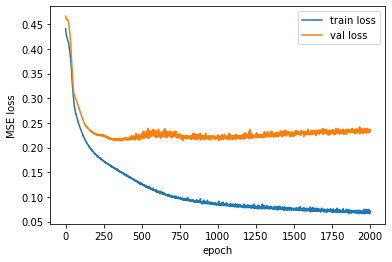

In [98]:
plt.plot(losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.legend()
plt.show()

## Save Checkpoint

In [99]:
PATH = "pose_plus_view_model.pt"

In [100]:
torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': losses[-1],
            'val_loss': val_losses[-1],
            }, PATH)

## Load Checkpoint

In [ ]:
model = Pose_plus_Ray_SwarmNet(pos_channels=3, hidden_channels=64, out_channels=1, 
                               conv_channels=3, conv_width=150).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
prev_train_loss = checkpoint['train_loss']
prev_val_loss = checkpoint['val_loss']

model.eval()

# Build Fish Model from Torch Model

In [101]:
class CouzinModel(fish_models.AbstractModel):
    def __init__(self, regressor, raycast, view_width):
        self.raycast = raycast
        self.regressor = regressor
        self.view_width = view_width
        self.chosen_actions = [[], []]

    def choose_action(self, poses_3d, self_id):
        speed = 8
        
        num_nodes = poses_3d.shape[0]
        list2 = []
        list1 = np.repeat(np.arange(num_nodes), num_nodes-1)
        for k in range(num_nodes):
            list2.append(np.concatenate((np.arange(num_nodes)[:k], np.arange(num_nodes)[k+1:])))
        list2 = np.concatenate(list2)
        edge_index = torch.tensor(np.array([list1, list2]), dtype=torch.long)
        x_pose = torch.tensor(poses_3d, dtype=torch.float)
        new_view = np.array([self.raycast.cast(poses_3d, new_id) for new_id in range(poses_3d.shape[0])])
        x_view = torch.tensor(np.stack((new_view.reshape(-1, new_view.shape[-1])[:,:self.view_width],
                              new_view.reshape(-1, new_view.shape[-1])[:,self.view_width:self.view_width*2],
                              new_view.reshape(-1, new_view.shape[-1])[:,self.view_width*2:self.view_width*3]), axis=1), 
                              dtype=torch.float)
        
        turn = self.regressor(x_pose, x_view, edge_index).detach().numpy()[self_id].item()
        self.chosen_actions[self_id].append(turn)
        return speed, turn

In [103]:
model.eval()
model.to("cpu")
raymodel = CouzinModel(regressor=model, raycast=raycast, view_width=150)
generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=25)

100%|███████████████████████████████████████| 749/749 [00:03<00:00, 231.93it/s]


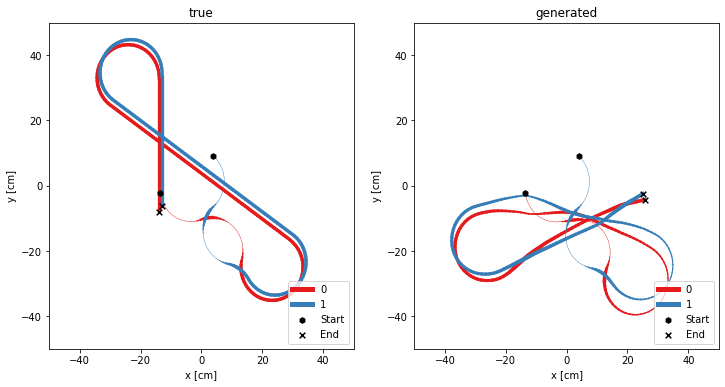

In [104]:
n=2
fig, axs = plt.subplots(1,2, figsize=(12,6))
f = generator.as_io_file(swarm_poses[0,:n,:,:])
f.plot(lw_distances=True, ax=axs[0])
axs[0].set_title("true")
track = generator.create_track(n_guppies=2, trackset_len=swarm_poses.shape[2], initial_poses=swarm_poses[0,:n,0,:])
f = generator.as_io_file(track)
f.plot(lw_distances=True, ax=axs[1])
axs[1].set_title("generated")
plt.show()

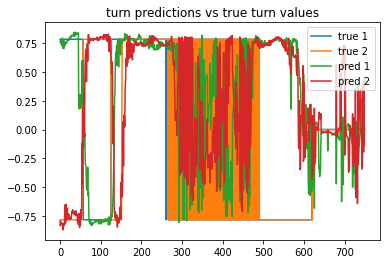

In [105]:
plt.plot(swarm_actions[0,0,:,1], label="true 1")
plt.plot(swarm_actions[0,1,:,1], label="true 2")
plt.plot(np.array(raymodel.chosen_actions)[0], label="pred 1")
plt.plot(np.array(raymodel.chosen_actions)[1], label="pred 2")
plt.title("turn predictions vs true turn values")
plt.legend()
plt.show()

100%|███████████████████████████████████████| 749/749 [00:03<00:00, 228.65it/s]


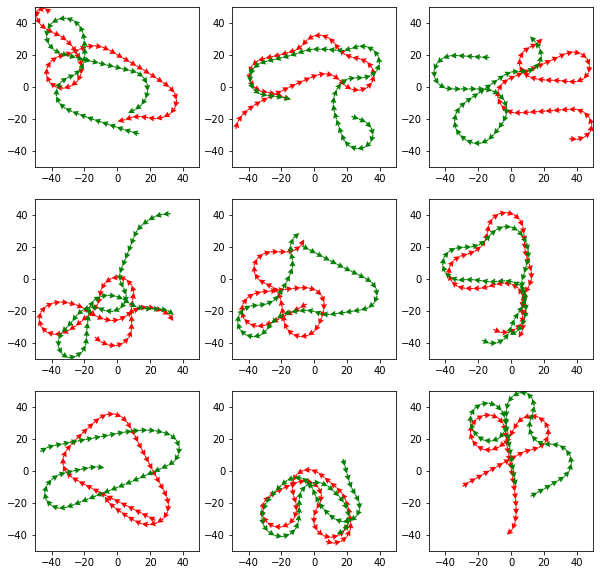

In [106]:
with torch.no_grad():
    model.eval()
    model.to("cpu")
    raymodel = CouzinModel(regressor=model, raycast=raycast, view_width=150)
    generator = fish_models.TrackGenerator([raymodel], world_size=[100,100], frequency=25)
colour_list = ["r", "g", "b", "y", "black"]
n = 2
fig, axs = plt.subplots(3,3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2], )
        for fish_id in range(n):
            a = track[fish_id, ::15, 0]
            b = track[fish_id, ::15, 1]
            axs[i,j].quiver(a[:-1], b[:-1], a[1:]-a[:-1], b[1:]-b[:-1], scale_units='xy', angles='xy', 
                            scale=1, headwidth=5, color = colour_list[fish_id])
            #axs[i,j].plot(track[fish_id, :, 0], track[fish_id, :, 1], label=fish_id)
        axs[i,j].set_xlim(-50,50)
        axs[i,j].set_ylim(-50,50)
plt.show()

100%|███████████████████████████████████████| 749/749 [00:03<00:00, 211.76it/s]


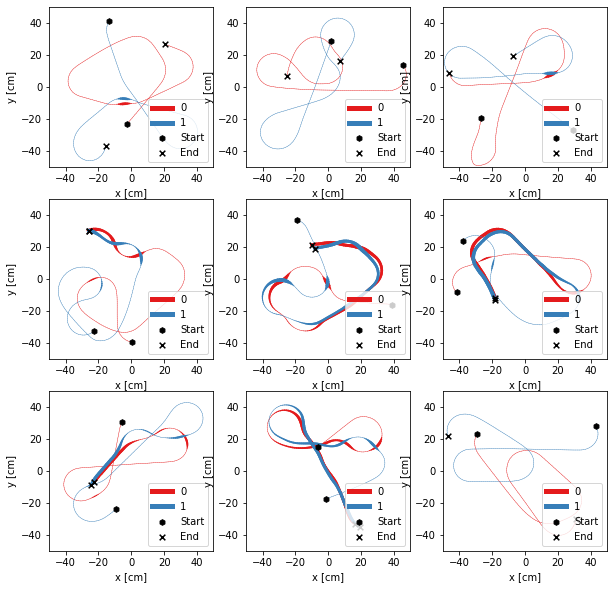

In [107]:
fig, axs = plt.subplots(3,3, figsize=(10,10))
for i in range(3):
    for j in range(3):
        track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
        f = generator.as_io_file(track)
        f.plot(lw_distances=True, ax=axs[i,j])
plt.show()

# Overarching Evaluation

In [108]:
paths = []
labels = []
model_path = r"D:\ResearchInternshipData\pose_plus_view_model"
model_label = "Model Data"
for i in range(50):
    track = generator.create_track(n_guppies=n, trackset_len=swarm_poses.shape[2])
    filename = r"D:\ResearchInternshipData\pose_plus_view_model\track_" + str(i+1) + ".hdf5"
    f = generator.as_io_file(track, filename)
    paths.append(filename)
    labels.append("track_" + str(i+1))
f.close() 

100%|███████████████████████████████████████| 749/749 [00:03<00:00, 234.22it/s]


In [109]:
import robofish.evaluate.evaluate as robo_eval

In [110]:
f1 = r"C:\Users\Olaf\OneDrive\Öffentlich\Master\ResearchInternship\couzin_torus\couzin_torus\train"

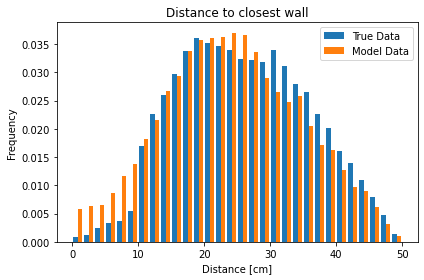

In [119]:
robo_eval.evaluate_distance_to_wall([f1, model_path], ["True Data", model_label])
plt.show()

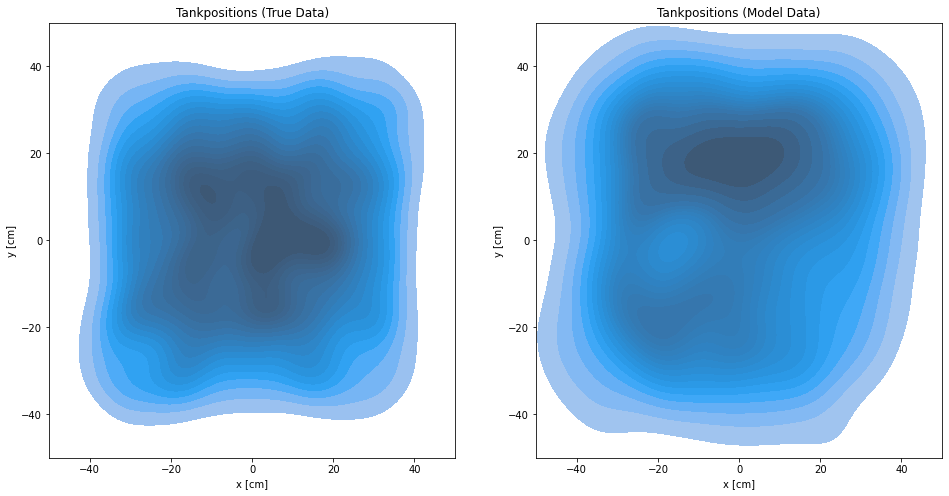

In [120]:
robo_eval.evaluate_tank_position([f1,model_path], ["True Data",model_label])
plt.show()

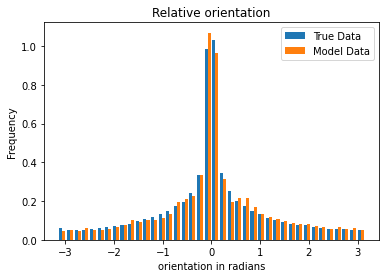

In [118]:
robo_eval.evaluate_relative_orientation([f1,model_path], ["True Data",model_label])
plt.show()

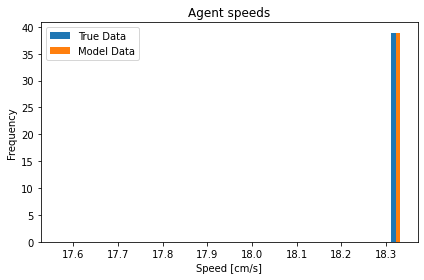

In [113]:
robo_eval.evaluate_speed([f1, model_path], ["True Data", model_label])
plt.show()

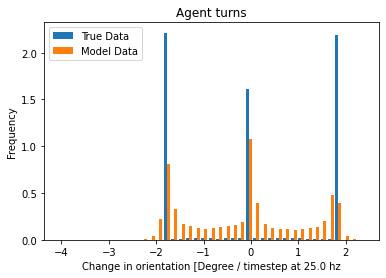

In [114]:
robo_eval.evaluate_turn([f1,model_path], ["True Data",model_label])
plt.show()

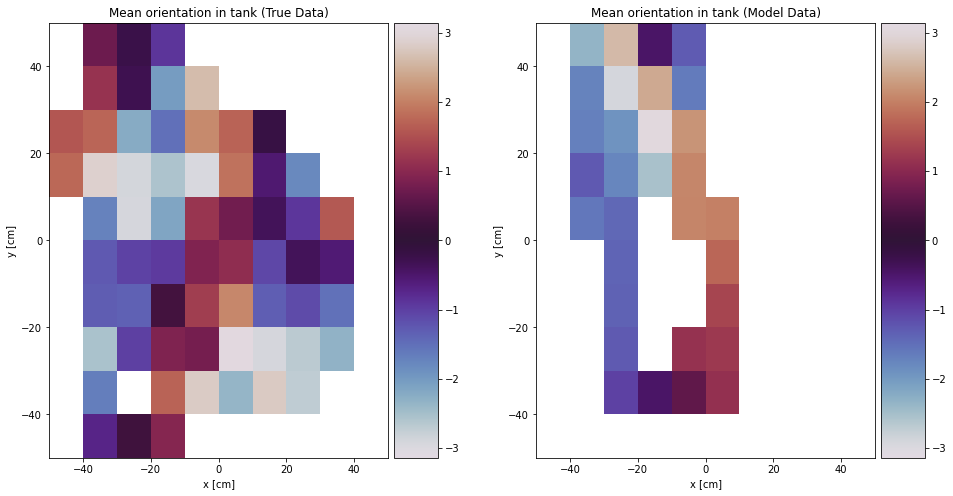

In [115]:
robo_eval.evaluate_orientation([f1, model_path], ["True Data", model_label])
plt.show()

<Figure size 576x576 with 0 Axes>

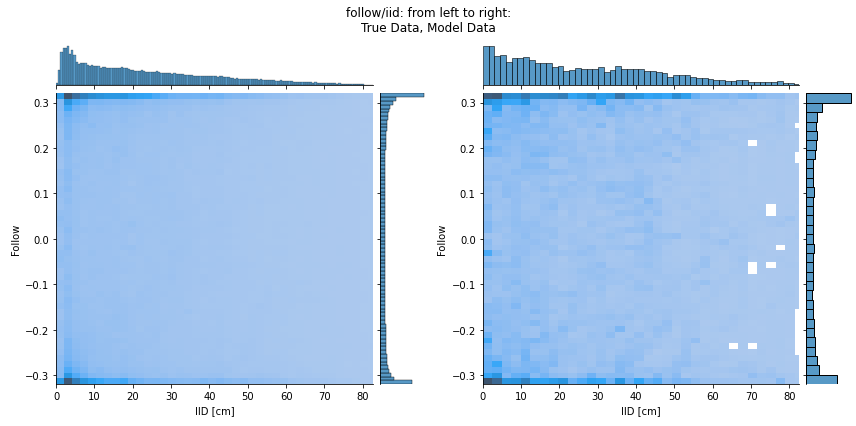

In [116]:
plt.figure(figsize=(8,8))
robo_eval.evaluate_follow_iid([f1, model_path], ["True Data", model_label])
plt.tight_layout()
plt.show()